In [1]:
import pandas as pd

import os

os.environ["PYTHONHASHSEED"] = str(221)

import random

random.seed(221)

import numpy as np

np.random.seed(221)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

tf.random.set_seed(221)

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from genetic_algo import GeneticAlgorithm, Individual
from simulated_annealing import SimulatedAnnealing
from pso import ParticleSwarmOptimization

2023-11-19 20:23:21.124555: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 20:23:21.685652: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-19 20:23:21.688582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 20:23:34.446144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_data(stock):
    filename = stock + ".csv"
    if os.path.exists(filename):
        return pd.read_csv(filename, parse_dates=True, index_col="Date")
    else:
        df = yf.download(stock)[["Close"]]
        df.to_csv(filename)
        return df


df = get_data("MSFT")
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-11-10,369.670013
2023-11-13,366.679993
2023-11-14,370.269989


In [3]:
def convertStringtoDate(s):
    l = s.split("-")
    y, m, d = int(l[0]), int(l[1]), int(l[2])
    return datetime(year=y, month=m, day=d)

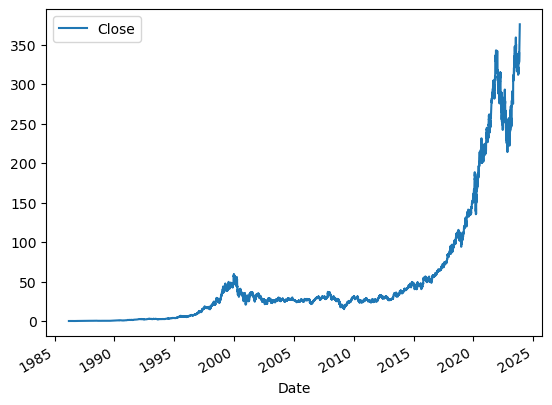

In [4]:
df.plot()

In [5]:
def getNextDateFromData(df, curr_date):
    ind = df.index.get_loc(curr_date)
    return df.index[ind + 1]

In [6]:
def createWindowedDataframe(df, start, end, w):
    start_date = convertStringtoDate(start)
    end_date = convertStringtoDate(end)
    curr_date = start_date
    reached_end = False

    dates = []
    features, target = [], []

    while not reached_end:
        df_window = df.loc[:curr_date].tail(w + 1)

        if len(df_window) != w + 1:
            raise Exception(f"Window size too large for date {curr_date}")

        closing_values = df_window["Close"].to_numpy()
        X, y = closing_values[:-1], closing_values[-1]

        dates.append(curr_date)
        features.append(X)
        target.append(y)

        if curr_date == end_date:
            reached_end = True
        else:
            curr_date = getNextDateFromData(df, curr_date)

    windowed_dataframe = pd.DataFrame({})
    windowed_dataframe["Target Date"] = dates
    features = np.array(features)

    for i in range(w):
        windowed_dataframe[f"Target-{w-i}"] = features[:, i]

    windowed_dataframe["Target"] = target
    return windowed_dataframe


windowed_dataframe = createWindowedDataframe(df, "2021-08-20", "2023-10-05", w=3)
windowed_dataframe

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-08-20,293.079987,290.730011,296.769989,304.359985
1,2021-08-23,290.730011,296.769989,304.359985,304.649994
2,2021-08-24,296.769989,304.359985,304.649994,302.619995
3,2021-08-25,304.359985,304.649994,302.619995,302.010010
4,2021-08-26,304.649994,302.619995,302.010010,299.089996
...,...,...,...,...,...
530,2023-09-29,312.140015,312.790009,313.640015,315.750000
531,2023-10-02,312.790009,313.640015,315.750000,321.799988
532,2023-10-03,313.640015,315.750000,321.799988,313.390015
533,2023-10-04,315.750000,321.799988,313.390015,318.959991


In [7]:
def train_val_test_split(windowed_dataframe, train_ratio, test_ratio):
    df = windowed_dataframe[:]
    dates = df.pop("Target Date")
    df = df.to_numpy()
    features = df[:, :-1]
    features = features.reshape((len(df), features.shape[1], 1)).astype(np.float32)
    target = df[:, -1].astype(np.float32)

    train_split_point = int(len(df) * train_ratio)
    test_split_point = int(len(df) * (1 - test_ratio))

    train_dates = dates[:train_split_point]
    train_X = features[:train_split_point]
    train_y = target[:train_split_point]

    val_dates = dates[train_split_point:test_split_point]
    val_X = features[train_split_point:test_split_point]
    val_y = target[train_split_point:test_split_point]

    test_dates = dates[test_split_point:]
    test_X = features[test_split_point:]
    test_y = target[test_split_point:]

    return (
        train_dates,
        train_X,
        train_y,
        val_dates,
        val_X,
        val_y,
        test_dates,
        test_X,
        test_y,
    )

In [8]:
def train(parameters, train_X, train_y, epochs=150, verbose=0):
    model = Sequential(
        [
            layers.Input((parameters["window_len"], 1)),
            layers.LSTM(parameters["hidden_units_1"], return_sequences=True),
            layers.LSTM(parameters["hidden_units_2"], activation="relu"),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
    model.fit(train_X, train_y, epochs=epochs, verbose=verbose)
    return model

In [9]:
def plot(dates, observed, predicted, label):
    plt.figure(figsize=(12, 7))
    plt.plot(dates, predicted)
    plt.plot(dates, observed)

    plt.legend([label + " Predictions", label + " Observations"])
    plt.show()

In [10]:
def decode_parameters(s):
    parameters = {}
    parameters["window_len"] = int(s[0:3], 2)
    parameters["hidden_units_1"] = int(s[3:11], 2)
    parameters["hidden_units_2"] = int(s[11:18], 2)
    return parameters

In [11]:
ga_fitness_values = {}

In [12]:
def ga_fitness(x: Individual):
    if x.gene in ga_fitness_values:
        return ga_fitness_values[x.gene]

    parameters = decode_parameters(x.gene)

    if (
        parameters["window_len"] == 0
        or parameters["hidden_units_1"] == 0
        or parameters["hidden_units_2"] == 0
    ):
        return float("inf")

    print(parameters)
    windowed_dataframe = createWindowedDataframe(
        df, "2021-08-20", "2023-10-05", w=parameters["window_len"]
    )
    (
        train_dates,
        train_X,
        train_y,
        val_dates,
        val_X,
        val_y,
        test_dates,
        test_X,
        test_y,
    ) = train_val_test_split(windowed_dataframe, 0.8, 0.1)
    model = train(parameters, train_X=train_X, train_y=train_y)
    ga_fitness_values[x.gene] = model.evaluate(val_X, val_y)
    return ga_fitness_values[x.gene]

# Running Genetic Algorithm


In [ ]:
ga = GeneticAlgorithm(3, 20, 18, 0.1, ga_fitness)
ind = ga.run()
best_param = decode_parameters(ind.gene)
print("Best params :")
print(best_param)
print("Val loss 1 :", ga_fitness_values[ind.gene])

In [ ]:
windowed_dataframe = createWindowedDataframe(
    df, "2021-08-20", "2023-10-05", w=best_param["window_len"]
)
(
    train_dates,
    train_X,
    train_y,
    val_dates,
    val_X,
    val_y,
    test_dates,
    test_X,
    test_y,
) = train_val_test_split(windowed_dataframe, 0.8, 0.1)
best_model = train(best_param, train_X=train_X, train_y=train_y, verbose=0, epochs=200)
best_model.evaluate(val_X, val_y)
best_model.evaluate(test_X, test_y)
test_predictions = best_model.predict(test_X)
plot(dates=test_dates, observed=test_y, predicted=test_predictions, label="Test")

# Simulated Annealing


In [ ]:
sa_fitness_values = {}


def sa_fitness(state, return_model=False):
    if state in sa_fitness_values:
        return sa_fitness_values[state]
    parameters = {
        "window_len": state[0],
        "hidden_units_1": state[1],
        "hidden_units_2": state[2],
    }

    print(parameters)
    windowed_dataframe = createWindowedDataframe(
        df, "2021-08-20", "2023-10-05", w=parameters["window_len"]
    )
    (
        train_dates,
        train_X,
        train_y,
        val_dates,
        val_X,
        val_y,
        test_dates,
        test_X,
        test_y,
    ) = train_val_test_split(windowed_dataframe, 0.8, 0.1)
    model = train(parameters, train_X=train_X, train_y=train_y)
    sa_fitness_values[state] = -model.evaluate(val_X, val_y)
    if return_model:
        return (sa_fitness_values[state], model)
    else:
        return sa_fitness_values[state]


def sa_constraint(_state):
    return True

In [ ]:
sa = SimulatedAnnealing(
    start_state=(
        np.random.randint(1, 10),
        np.random.randint(2, 256),
        np.random.randint(2, 128),
    ),
    T=50,
    Tmin=0.1,
    k=0.9,
    n=3,
    f=sa_fitness,
    constraint=sa_constraint,
    min_state=(1, 1, 1),
)
sa_params = sa.run()
sa_params

In [ ]:
params = {
    "window_len": sa_params[0],
    "hidden_units_1": sa_params[1],
    "hidden_units_2": sa_params[2],
}

windowed_dataframe = createWindowedDataframe(
    df, "2021-08-20", "2023-10-05", w=params["window_len"]
)
(
    train_dates,
    train_X,
    train_y,
    val_dates,
    val_X,
    val_y,
    test_dates,
    test_X,
    test_y,
) = train_val_test_split(windowed_dataframe, 0.8, 0.1)
best_model = train(params, train_X=train_X, train_y=train_y, verbose=0, epochs=200)
best_model.evaluate(val_X, val_y)
best_model.evaluate(test_X, test_y)
test_predictions = best_model.predict(test_X)
plot(dates=test_dates, observed=test_y, predicted=test_predictions, label="Test")

# Particle Swarm Optimization


In [13]:
pso_fitness_values = {}


def pso_fitness(x):
    key = tuple(x.tolist())

    if key in pso_fitness_values:
        return pso_fitness_values[key]
    
    parameters = {'window_len': x[0], 'hidden_units_1': x[1], 'hidden_units_2': x[2]}
    windowed_dataframe = createWindowedDataframe(df, '2021-08-20', '2023-10-05', w=parameters['window_len'])
    train_dates, train_X, train_y, val_dates, val_X, val_y, test_dates, test_X, test_y = train_val_test_split(windowed_dataframe, 0.8, 0.1)
    model = train(parameters, train_X=train_X, train_y=train_y)
    pso_fitness_values[key] = model.evaluate(val_X, val_y)
    return pso_fitness_values[key]

In [14]:
pso = ParticleSwarmOptimization(
    n = 5,
    c1 = 0.5,
    c2 = 0.5,
    fitness = pso_fitness
)

pso_params = pso.run(epochs=20)
print(pso_params)


Iteration 1
2/2 [==============================] - 1s 12ms/step - loss: 31.6789
Current fitness : 31.678892135620117 , Local best fitness : 31.678892135620117 , Global best fitness : 31.678892135620117
2/2 [==============================] - 1s 11ms/step - loss: 40.9876
Current fitness : 40.98762893676758 , Local best fitness : 40.98762893676758 , Global best fitness : 31.678892135620117
2/2 [==============================] - 1s 6ms/step - loss: 114.8679
Current fitness : 114.86785888671875 , Local best fitness : 114.86785888671875 , Global best fitness : 31.678892135620117
2/2 [==============================] - 1s 5ms/step - loss: 68.5109
Current fitness : 68.51093292236328 , Local best fitness : 68.51093292236328 , Global best fitness : 31.678892135620117
2/2 [==============================] - 0s 5ms/step - loss: 79.2914
Current fitness : 79.29142761230469 , Local best fitness : 79.29142761230469 , Global best fitness : 31.678892135620117

Iteration 2
Current fitness : 31.67889213562

2/2 [==============================] - 1s 4ms/step


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


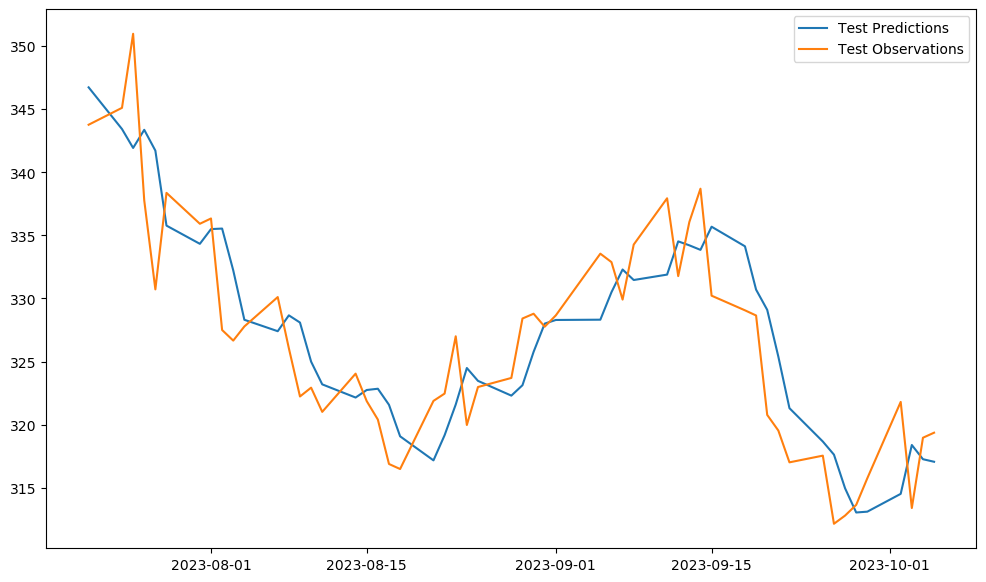

In [15]:
params = {'window_len': pso_params[0], 'hidden_units_1': pso_params[1], 'hidden_units_2': pso_params[2]}

windowed_dataframe = createWindowedDataframe(df, '2021-08-20', '2023-10-05', w=params['window_len'])
train_dates, train_X, train_y, val_dates, val_X, val_y, test_dates, test_X, test_y = train_val_test_split(windowed_dataframe, 0.8, 0.1)
best_model = train(params, train_X=train_X, train_y=train_y, verbose=0, epochs=200)
best_model.evaluate(val_X, val_y)
best_model.evaluate(test_X, test_y)
test_predictions = best_model.predict(test_X)
plot(dates=test_dates, observed=test_y, predicted=test_predictions, label='Test')
